In [ ]:
# Section E Feature Engineering...........

# Removing additional columns that are no longer needed
flighttest_df = flightpredict_df.drop(['startingAirport', 'destinationAirport', 'firstSegmentDeparture', 'lastSegmentArrival', 'departureYear', 'arrivalYear', 'arrivalMonth', 'arrivalSecond', 'departureSecond', 'segmentsAirlineName', 'segmentsArrivalTimeEpochSeconds', 'segmentsDepartureTimeEpochSeconds'], axis=1)

# Function to classify the time of day based on hour
def classify_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the classify_time function to create new columns for arrival and departure times of day
flighttest_df['arrives'] = flighttest_df['arrivalHour'].apply(classify_time)
flighttest_df['departs'] = flighttest_df['departureHour'].apply(classify_time)

# Function to classify the season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the get_season function to create a new column for season
flighttest_df['season'] = flighttest_df['flightDate'].dt.month.apply(get_season)

# Combine airport name and city name into a single column for starting and destination airports
flighttest_df['startingAirportCityName'] = flighttest_df['startingAirportName'] + ' - ' + flighttest_df['startingCityName']
flighttest_df['destinationAirportCityName'] = flighttest_df['destinationAirportName'] + ' - ' + flighttest_df['destinationCityName']

# Convert data types to optimize memory usage
flighttest_df = flighttest_df.convert_dtypes()

# Select relevant columns for prediction
predict_df = flighttest_df[['totalFare', 'departureDate', 'departureMonth', 'departureHour', 'departureMinute', 'arrivalDate', 'arrivalHour', 'arrivalMinute', 'travelDuration', 'airlineName', 'startingAirportCityName', 'destinationAirportCityName', 'seatsRemaining', 'numberOfStops', 'totalTravelDistance', 'isBasicEconomy', 'isRefundable', 'arrives', 'departs', 'season']]

# List of columns to encode
columns_to_encode = ['airlineName', 'startingAirportCityName', 'destinationAirportCityName', 'arrives', 'departs', 'season']

# Loop through the columns and encode them using one-hot encoding
for column in columns_to_encode:
    # Encode the column
    encoded_data = pd.get_dummies(predict_df[column], prefix=column, dtype=int)
    # Concatenate the encoded data to the original DataFrame
    predict_df = pd.concat([predict_df, encoded_data], axis=1)
    # Drop the original column
    predict_df.drop(column, axis=1, inplace=True)


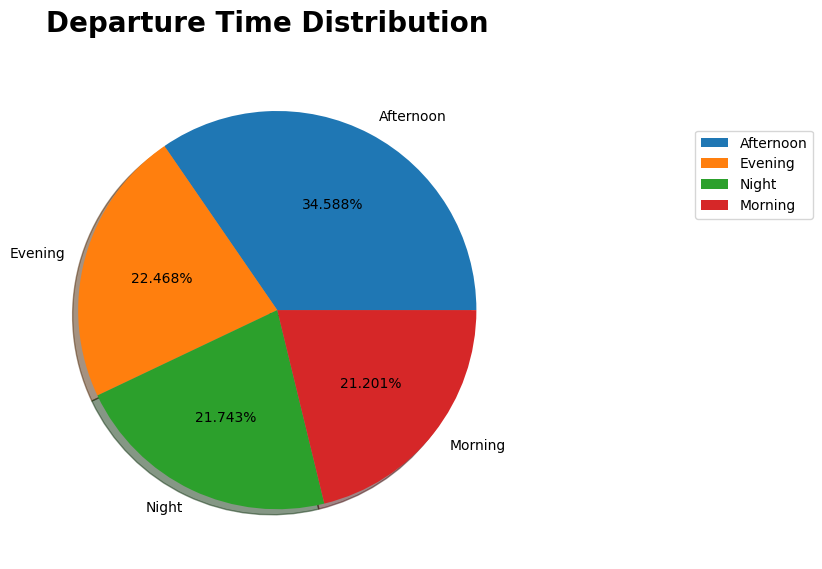

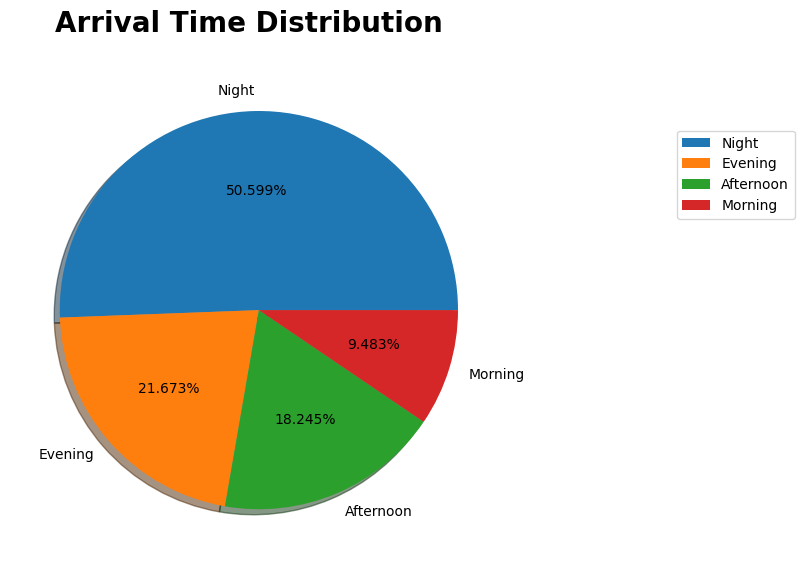

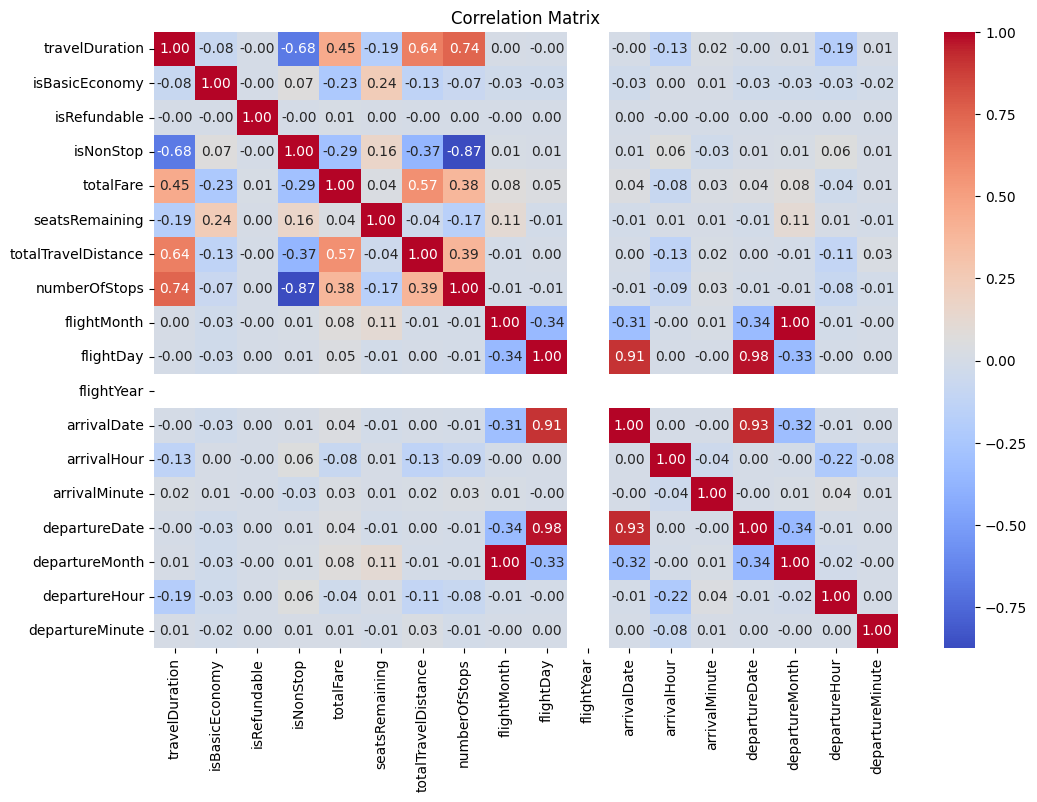

In [ ]:

# Pie Chart for Departure Time Analysis
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Departure Time Distribution', fontsize=20, fontweight='bold')
plt.tight_layout()
labels = flighttest_df.departs.value_counts().index.tolist()
sizes = flighttest_df.departs.value_counts().values.tolist()
ax.pie(sizes, autopct='%.3f%%', labels=labels, shadow=True, pctdistance=0.6, labeldistance=1.1)
ax.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=5)
plt.show()

#Pie Chart for Arrival Time Analysis
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Arrival Time Distribution', fontsize=20, fontweight='bold')
plt.tight_layout()
labels = flighttest_df.arrives.value_counts().index.tolist()
sizes = flighttest_df.arrives.value_counts().values.tolist()
ax.pie(sizes, autopct='%.3f%%', labels=labels, shadow=True, pctdistance=0.6, labeldistance=1.1)
ax.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=5)
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
numerical_features = flighttest_df.select_dtypes(include=np.number)
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# # Section F Modeling and Evaluation...........

# # Model 1 - XGB with hyperparameter tuning

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

# Assuming 'totalFare' is the target variable
y = predict_df['totalFare']
X = predict_df.drop(['totalFare'], axis=1)

# Random sampling to split the data
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.8, random_state=42)

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

# Hyperparameter tuning using RandomizedSearchCV for XGBoost
param_dist_xgb = {
    'n_estimators': randint(100, 150),
    'max_depth': randint(10, 15),
    'learning_rate': uniform(0.01, 0.05),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

xgb_reg = XGBRegressor(random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_dist_xgb, n_iter=10, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV for XGBoost
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")


Best parameters for XGBoost: {'colsample_bytree': 0.8749080237694725, 'learning_rate': 0.05753571532049581, 'max_depth': 12, 'n_estimators': 107, 'subsample': 0.9197316968394074}


In [ ]:
# Training XGB with best parameters & performing cross validation

import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'predict_df' is your DataFrame and 'best_params_xgb' contains the best parameters
X = predict_df.drop(columns=['totalFare'])
y = predict_df['totalFare']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the XGBoost model with the best parameters from RandomizedSearchCV
xgb_model = xgb.XGBRegressor(
    **best_params_xgb,
    random_state=42
)

# Performing cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
xgb_model.fit(X_train, y_train)

# Making predictions
predictions = xgb_model.predict(X_test)

# Calculating evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Printing evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Printing cross-validation scores
print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean Cross-Validation MSE: {-cv_scores.mean()}")

Mean Squared Error (MSE): 11603.202710678472
Mean Absolute Error (MAE): 66.39675009683319
R-squared (R2): 0.7391862869262695
Cross-Validation MSE Scores: [12337.4997097  12124.4499534  11934.89423497 12550.1608152
 11697.06787523]
Mean Cross-Validation MSE: 12128.814517699297


In [ ]:
import pandas as pd
from scipy.stats import skew

# Step 1: Check skewness of the target variable 'totalFare'
target = predict_df['totalFare']
skewness = skew(target)
print(f'Skewness: {skewness}')

Skewness: 2.249598535958815


In [ ]:
# Step 2: Identify outliers
Q1 = predict_df['totalFare'].quantile(0.25)
Q3 = predict_df['totalFare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = predict_df[(predict_df['totalFare'] < lower_bound) | (predict_df['totalFare'] > upper_bound)]

outlier_summary = outliers['totalFare'].describe()
print(outlier_summary)

count        12456.0
mean     1274.467175
std       442.205668
min           911.61
25%           986.61
50%         1088.155
75%        1442.6225
max           7568.6
Name: totalFare, dtype: Float64


In [ ]:
# Step 3: Cap the outliers
cap_value = upper_bound
predict_df['totalFare'] = predict_df['totalFare'].clip(upper=cap_value)

# Step 4: Recheck the distribution after capping
new_skewness = skew(predict_df['totalFare'])
print(f'New Skewness: {new_skewness}')

# Summary statistics after capping
summary_after_capping = predict_df['totalFare'].describe()
print(summary_after_capping)

New Skewness: 0.6232490633076826
count      916976.0
mean     381.652671
std       187.81954
min           23.97
25%           232.6
50%           356.6
75%           504.2
max           911.6
Name: totalFare, dtype: Float64


In [ ]:
# Retraining XGB and cross-training after handling outliers

import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'predict_df' is your DataFrame and 'best_params_xgb' contains the best parameters
X = predict_df.drop(columns=['totalFare'])
y = predict_df['totalFare']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the XGBoost model with the best parameters from RandomizedSearchCV
xgb_model = xgb.XGBRegressor(
    **best_params_xgb,
    random_state=42
)

# Performing cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
xgb_model.fit(X_train, y_train)

# Making predictions
predictions = xgb_model.predict(X_test)

# Calculating evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Printing evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Printing cross-validation scores
print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean Cross-Validation MSE: {-cv_scores.mean()}")

Mean Squared Error (MSE): 7144.701894643266
Mean Absolute Error (MAE): 61.754666919968244
R-squared (R2): 0.7965903282165527
Cross-Validation MSE Scores: [7232.8684807  7183.32514033 7105.35601023 7215.62607827 7137.26807741]
Mean Cross-Validation MSE: 7174.888757388867
